# Exploring Cell Coverage of Routes
* To do later: move data sources to a catalog
* An agency here is defined: as a service and an operator...

In [53]:
# Read in zip files
import fsspec

# Other
import geopandas as gpd
import numpy as np
import pandas as pd
# import shared_utils
from calitp import *

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils

In [54]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [55]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## California County Borders

In [56]:
ca_gdf = gpd.read_file(
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
)

## Trip Routes 

In [57]:
routes_df = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes.parquet"
)

In [58]:
routes_df["route_type"].value_counts()

3    7397
2     183
0     119
4      57
5      31
1       4
Name: route_type, dtype: int64

In [59]:
routes_subset = routes_df[["route_type", "route_name", "agency"]]

In [60]:
cols_without_geometry = [
    "agency",
    "route_name",
    "itp_id",
    "route_id",
    "shape_id",
    "route_type",
]

In [61]:
# Drop Amtrak
routes_df2 = routes_df.loc[routes_df["agency"] != "Amtrak"]

In [62]:
# Filter for only bus routes
routes_df2 = routes_df.loc[routes_df["route_type"] == "3"]

In [168]:
# routes_df2[['agency','route_name']].sample(10)

In [63]:
# Drop Bay Area Ferry Service - ferry only
# routes_df2 = routes_df2.loc[routes_df2["agency"] != "San Francisco Bay Ferry"]

In [64]:
f"{len(routes_df2)} rows left after dropping - compared to {len(routes_df)} rows before."

'7397 rows left after dropping - compared to 7791 rows before.'

In [65]:
# Fill in NA for route names and agency names
routes_df2[["agency", "route_name"]] = routes_df2[["agency", "route_name"]].fillna(
    "None"
)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [193]:
# Keep only one row per route_id
# is there another way I should pick each route?
routes_df3 = routes_df2.drop_duplicates(subset=["route_id"])

In [199]:
# Keep only one instance of a unique ITP ID - route_name combo
routes_df3 = routes_df3.drop_duplicates(subset=["itp_id", "route_name"])

In [200]:
# Reset index after dropping
routes_df3 = routes_df3.reset_index()

In [201]:
f"{routes_df3.route_id.nunique()} unique route ids, {routes_df3.route_name.nunique()} different route names, and {routes_df3.shape_id.nunique()} different shape ids."

'1424 unique route ids, 1374 different route names, and 1402 different shape ids.'

In [198]:
routes_df3.shape

(1657, 8)

## FCC AT&T Data Map 
* Testing with AT&T first.

### Clip AT&T map to only include California Counties

In [236]:
def create_california_coverage(file_zip_name:str, new_file_name:str):
    
    # Open zip file first
    PATH = f"{GCS_FILE_PATH}{file_zip_name}"
    with fsspec.open(PATH) as file:
        fcc_gdf = gpd.read_file(file)
    
    # Open file with California Counties.
    ca_gdf = gpd.read_file(
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson")

    # Clip 
    fcc_ca_gdf = gpd.clip(fcc_gdf, ca_gdf)

    # Save this into a parquet so don't have to clip all the time
    utils.geoparquet_gcs_export(fcc_ca_gdf, GCS_FILE_PATH, new_file_name)


In [112]:
# Open
fcc_ca_gdf = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/AT_T_Data_California_Only.parquet"
)

In [113]:
# fcc_ca_gdf.plot(figsize = (30,12))

## Overlay 
* I want to obtain routes that are NOT contained in the AT & T coverage map.
* https://geopandas.org/en/stable/docs/user_guide/set_operations.html
* To obtain the geometries that are part of df1 but are not contained in df2, you can use how='difference'.

In [114]:
# Check that they are the same CRS
fcc_ca_gdf.crs == routes_df3.crs

True

In [115]:
# Reproject
fcc_ca_gdf = fcc_ca_gdf.to_crs("epsg:3395")
routes_df3 = routes_df3.to_crs("epsg:3395")

In [116]:
overlay_df = routes_df3.overlay(fcc_ca_gdf, how="difference")

In [117]:
overlay_df.shape

(239, 8)

<AxesSubplot:>

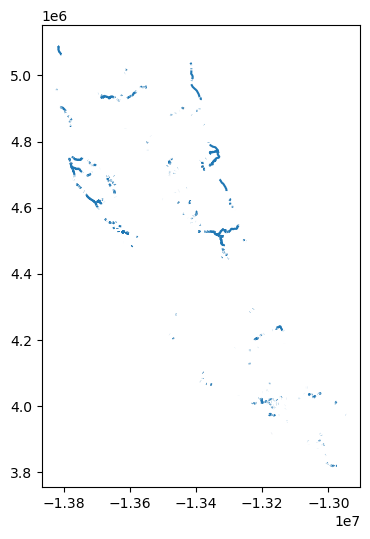

In [118]:
# Change to overlay later
(overlay_df.plot(figsize=(12, 6), markersize=30))

In [145]:
display(
    Markdown(
        f"""There are {overlay_df['route_id'].nunique()} routes (run by {overlay_df['agency'].nunique()} different agencies) 
        w/o overlap to the AT&T coverage map. In comparison, there are {routes_df3.route_id.nunique()} total routes in the original dataframe."""
    )
)

There are 239 routes (run by 62 different agencies) 
        w/o overlap to the AT&T coverage map. In comparison, there are 1424 total routes in the original dataframe.

In [120]:
# Previewing the routes left
# overlay_df[cols_without_geometry].sort_values('route_name')

In [150]:
# Agencies with the most routes without coverage.
(
    overlay_df.groupby(["agency"])
    .agg({"route_id": "nunique"})
    .rename(columns={"route_id": "total_routes"})
    .sort_values("total_routes", ascending=False)
    .head(10)
)

,total_routes
agency,
AC Transit,34
Metro,30
Marin Transit,14
Los Angeles Department of Transportation,11
Tahoe Transportation,9
Golden Gate Bridge Highway and Transportation District,9
Kern Transit,8
North County Transit District,7
Avocado Heights/Bassett/West Valinda Shuttle,7


In [123]:
# List for unique itp_ids
agencies_no_coverage = overlay_df["itp_id"].unique().tolist()

In [170]:
# List for unique route ids
routes_no_coverage = overlay_df["route_id"].unique().tolist()

In [125]:
# List for unique route ids
routes_no_coverage_name = overlay_df["route_name"].unique().tolist()

In [126]:
# A table with all the itp id & agencies
agency_df = overlay_df[["agency", "itp_id"]].drop_duplicates().reset_index()

In [127]:
# Subset of overlap without geometry for when I wnat to preview the df
overlay_df_no_geo = overlay_df[
    ["itp_id", "route_id", "shape_id", "route_type", "route_name", "agency"]
]

In [206]:
# Surprised by AC Transit
overlay_df_no_geo.loc[overlay_df["agency"] == "AC Transit"]

,itp_id,route_id,shape_id,route_type,route_name,agency
0,4,19,shp-19-64,3,Buena Vista - Fruitvale,AC Transit
1,4,20,shp-20-03,3,Dimond - Fruitvale - South Shore,AC Transit
2,4,21,shp-21-20,3,Dimond - Fruitvale - Bay Farm,AC Transit
3,4,33,shp-33-17,3,Piedmont - Harrison - Park Blvd.,AC Transit
4,4,51A,shp-51A-17,3,Broadway - Santa Clara,AC Transit
5,4,606,shp-606-02,3,Head Royce - Piedmont,AC Transit
6,4,631,shp-631-03,3,Encinal - Alameda - Bay Farm,AC Transit
7,4,687,shp-687-01,3,Lincoln Middle - Bay Farm,AC Transit
8,4,688,shp-688-09,3,St. Mary's College - Montclair,AC Transit
9,4,701,shp-701-03,3,Pittsburg/BP Transbay Early Bird,AC Transit


## Trips
* How many trips are running for a route?

In [129]:
trips_df = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/trips_2022-05-04_all.parquet"
)

In [130]:
trips_df.shape

(104934, 14)

In [131]:
trips_df.head(1)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_short_name,route_long_name,route_desc,route_type
0,4,0,2022-05-04,1582047897989018365,272020,21,1,shp-21-23,2022-03-26,2099-01-01,21,Dimond - Fruitvale - Bay Farm,None,3


In [132]:
# Add agency name
trips_df = pd.merge(
    trips_df, agency_df, how="inner", left_on="calitp_itp_id", right_on="itp_id"
)

In [133]:
# Try to standardize route id for the 2 dfs
overlay_df["route_id"] = overlay_df["route_id"].str.lower().str.strip()
trips_df["route_id"] = trips_df["route_id"].str.lower().str.strip()

In [134]:
# Filter out for route IDS
trips_df2 = trips_df[trips_df["route_id"].isin(routes_no_coverage)]

In [135]:
# So many route ids disappeared
f'{trips_df2["route_id"].nunique()} routes left after filtering trips_df compared to {len(routes_no_coverage)} routes in overlay.'

'142 routes left after filtering trips_df compared to 239 routes in overlay.'

In [136]:
# Checking which ones are missing.
id_routes = set(routes_no_coverage)
id_trips = set(trips_df2.route_id.unique().tolist())
missing_routes = list(id_routes - id_trips)

In [138]:
f"{len(missing_routes)/len(routes_no_coverage)}% of routes missing"

'0.40585774058577406% of routes missing'

In [140]:
# Sum up number of trips taken by route using trip id?
trips_ran = (
    trips_df2.groupby(["calitp_itp_id", "route_long_name", "agency"])
    .agg({"trip_id": "count"})
    .reset_index()
    .rename(columns={"trip_id": "total_trips"})
)

In [141]:
trips_ran.shape

(167, 4)

In [208]:
# trips_ran

In [143]:
trips_ran["agency"].nunique()

46

## NTD 

In [176]:
ntd_df = pd.read_excel(
    f"gs://calitp-analytics-data/data-analyses/5311 /2020-Vehicles_1.xlsm",
    sheet_name="Vehicle Type Count by Agency",
)

In [218]:
# ntd_df.columns

In [225]:
# Only get bus related columns
columns_wanted = [
    "Agency",
    "City",
    "State",
    "Bus",
    "Over-The-Road Bus",
    "Articulated Bus",
    "Double Decker Bus",
    "School Bus",
    "Van",
    "Cutaway",
    "Minivan",
]

In [226]:
# Have to add snakecase after b/c some columns have integers
ntd_df2 = to_snakecase(ntd_df[columns_wanted])

In [227]:
# Only grab California
ntd_df2 = ntd_df2.loc[ntd_df2["state"] == "CA"]

In [228]:
# Add up buses
ntd_df2["total_buses"] = ntd_df2.sum(numeric_only=True, axis=1)

In [232]:
# Drop agencies with 0 buses
ntd_df2 = ntd_df2.loc[ntd_df2['total_buses'] !=0]

In [234]:
ntd_df2.shape

(218, 12)